# Make confidence interval for the ML parameter estimation of the generated data

In [1]:
import pandas as pd
import numpy as np
from src.data_generator import generate_default_buckets
from scipy.stats import norm

In [2]:
# Fix seed for reproducibility
seed = 2523
np.random.seed(seed)

In [3]:
factor_loading_list = [0.45, 0.45, 0.45]
pd_list = [0.0015, 0.0100, 0.0500]
gamma_list = norm.ppf(pd_list)
#num_of_obligors_list = [250, 250, 250]
num_of_obligors_list = [400, 250, 100]

# Make a pandas dataframe with Grade, Factor Loading, PD, Gamma, Num of Obligors
df = pd.DataFrame({'Grade': ['A', 'B', 'C'], 'Factor Loading': factor_loading_list, 'PD': pd_list, 'Gamma': gamma_list, 'Num of Obligors': num_of_obligors_list})
df

,Grade,Factor Loading,PD,Gamma,Num of Obligors
0,A,0.45,0.0015,-2.967738,400
1,B,0.45,0.0100,-2.326348,250
2,C,0.45,0.0500,-1.644854,100


In [10]:
length_of_time_series = 80
default_list = generate_default_buckets(factor_loading_list,num_of_obligors_list, gamma_list, time_points=length_of_time_series)
print("Number of defaults: ", default_list)
num_of_obligors_over_time = [x * length_of_time_series for x in num_of_obligors_list]
print("Number of obligors over time: ", num_of_obligors_over_time)

Number of defaults:  [97, 327, 485]
Number of obligors over time:  [32000, 20000, 8000]


In [11]:
# Empirical PD
empirical_pd_list = [x/y for x, y in zip(default_list, num_of_obligors_over_time)]
print("Empirical PD: ", empirical_pd_list)

Empirical PD:  [0.00303125, 0.01635, 0.060625]


In [6]:
gamma_list = [-2.9, -2.3, -1.6]
norm.cdf(gamma_list)

array([0.00186581, 0.01072411, 0.05479929])

In [7]:
from src.ML_estimation import calculate_my_likelihood_arr
from src.sucess_probability import p_g
from scipy.optimize import minimize

def parameter_estimation(default_list, num_of_obligors_over_time, factor_loading_init, gamma_list_init):
    initial_guess = gamma_list_init + factor_loading_init
    
    num_of_gamma = len(gamma_list_init)
    num_of_factor_loading = len(factor_loading_init)
    # bound = num_of_gamma * (-5, 5) + num_of_factor_loading * (-1, 1)
    bounds = num_of_gamma * [(-5, 5)] + num_of_factor_loading * [(-1, 1)]
    print(bounds)
    print(initial_guess)
    # Optimization
    objective_function = lambda params: -np.log(calculate_my_likelihood_arr(
        default_list, num_of_obligors_over_time, p_g, norm.pdf, np.repeat(params[3], 3), params[0:3]
    ))
    
    result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': True})
    
    return result

In [8]:
# Test the parameter estimation
factor_loading_init = [0.40]
gamma_list_init = [-2.9, -2.2, -1.6]
result = parameter_estimation(default_list, num_of_obligors_over_time, factor_loading_init, gamma_list_init)

[(-5, 5), (-5, 5), (-5, 5), (-1, 1)]
[-2.9, -2.2, -1.6, 0.4]
Optimization terminated successfully.
         Current function value: 11.014011
         Iterations: 249
         Function evaluations: 424


In [9]:
result.x[3]

1.1522589899534333e-05

In [10]:
# Confidence interval for the ML parameter estimation
list_of_len_ts = [20, 30, 80, 160]
num_of_simulations = 100

# Create a dictionary to store the results
# make the keys of the dictionary the length of the time series
results = {key: [] for key in list_of_len_ts}
for _ in range(num_of_simulations):
    for len_ts in list_of_len_ts:
        default_list = generate_default_buckets(factor_loading_list,num_of_obligors_list, gamma_list, time_points=len_ts)
        num_of_obligors_over_time = [x * len_ts for x in num_of_obligors_list]
        d_g_arr = np.array(default_list)
        n_g_arr = np.array(num_of_obligors_over_time)
        gamma_g = norm.ppf(d_g_arr / n_g_arr)
        initial_guess = np.array(gamma_g)
        initial_guess = np.append(initial_guess, 0.45)
        bounds = [(-5, 5), (-5, 5), (-5, 5), (-1, 1)]
        objective_function = lambda params: -np.log(calculate_my_likelihood_arr(d_g_arr, n_g_arr, p_g, norm.pdf, 
                                                                 np.repeat(params[3], 3), 
                                                                 params[0:3]))
        result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': False})
        results[len_ts].append(result.x[3])

KeyboardInterrupt: 

In [18]:
import csv

# Fájl neve, amibe kiírod
fajl_nev = "adatok.csv"

# Kiírás CSV-be
with open(fajl_nev, "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    for kulcs, ertek in results.items():
        csv_writer.writerow([kulcs, ertek])

In [35]:
import csv
file_name = "data_variable_change.csv"

return_data = {}
with open(file_name, "r", newline="") as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        return_data[row[0]] = row[1]

results = return_data

In [36]:
print(type(results))
print(results.keys())

<class 'dict'>
dict_keys(['100', '200', '300', '500'])


In [37]:
results

{'100': '[-3.954741676226937e-06, -4.169729787865443e-06, -2.2561185562170657e-05, 8.472309165690303e-06, -3.878210393467119e-05, 5.15501922976395e-06, 7.147475223844656e-06, 1.6333932857067317e-05, 2.4238871395438084e-05, -2.430668682814424e-06]',
 '200': '[0.2596942429758074, -1.9984866692475695e-05, -3.661882514874846e-05, 1.4336196733970221e-05, -1.173912710743653e-05, 0.46293277796209376, -4.1410029609961255e-06, -0.03478601988220862, 0.45471911255550934, -0.018755188533190692]',
 '300': '[0.44770750990613767, 0.46105002822318286, 0.038636172212812514, 0.44878729199229284, 0.4527353288824286, 0.3778998767705431, 0.4467530597305152, 0.45317294122015234, 0.45158992427371086, -7.511229378146125e-06]',
 '500': '[0.4525865380784997, 0.473848617511862, 0.46350575090299184, -0.0030051004515318177, -4.774504982658473e-06, 0.45142113909798204, 0.45260120468632203, 0.4377342192663827, 0.44703355663224165, 1.227431946423175e-05]'}

In [38]:
# A dictionary értékeinek átalakítása listákká
for key, value in results.items():
    # Eltávolítjuk a '[' és ']' karaktereket, majd szóközök mentén szétválasztjuk az elemeket
    value_list = value.strip('[]').split(', ')
    # Az így kapott stringeket int számmá alakítjuk
    value_list = [float(num_str) for num_str in value_list]
    # Az eredményt frissítjük az új listával
    results[key] = value_list

x = list(results.keys())
y_mean = [np.mean(results[key]) for key in x]

y_mean

[-1.0550821771944338e-06,
 0.11237467774528354,
 0.3578324621982398,
 0.3175733425539232]

In [ ]:
# To-do: make a module for optimization which gives back 2 list of parameters: one for the factor_loading and one for the gamma
# Then use these parameters to make the confidence interval, dict['len_ts']['grade']['factor_loading'] = list of factor_loadings
# Make it with MM and 3 type ML

In [3]:
import numpy as np
from src.ML_estimation import gen_data_and_mle

In [16]:
np.random.seed(42)
time_horizon = 40
factor_loading_list = [0.45, 0.45, 0.45]
num_of_obligors_list = [3000, 3000, 3000]
gamma_list = [-2.9, -2.3, -1.6]
factor_loading_init = [0.447]
gamma_list_init = [-2.91, -2.29, -1.603]

In [17]:
results_20 = {}

for i in range(100):
    temp_result_20 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_20[i] = temp_result_20

In [18]:
results_30 = {}

for i in range(100):
    temp_result_30 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_30[i] = temp_result_30

In [19]:
results_80 = {}

for j in range(100):
    temp_result_80 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_80[j] = temp_result_80

In [20]:
results_160 = {}

for k in range(100):
    temp_result_160 = gen_data_and_mle(time_horizon, num_of_obligors_list, factor_loading_list, gamma_list, factor_loading_init, gamma_list_init)
    results_160[k] = temp_result_160

C:\Users\kissp\PycharmProjects\VasicekPDModell\src\ML_estimation.py:185: RuntimeWarning: divide by zero encountered in log
  objective_function = lambda params: -np.log(calculate_my_likelihood_arr(


In [33]:
import pandas as pd
df_20 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_20.loc[i, "n_1"] = list(results_20.values())[i][0][0]
    df_20.loc[i, "n_2"] = list(results_20.values())[i][0][1]
    df_20.loc[i, "n_3"] = list(results_20.values())[i][0][2]
    df_20.loc[i, "d_1"] = list(results_20.values())[i][1][0]
    df_20.loc[i, "d_2"] = list(results_20.values())[i][1][1]
    df_20.loc[i, "d_3"] = list(results_20.values())[i][1][2]
    df_20.loc[i, "gamma_1"] = list(results_20.values())[i][2][0]
    df_20.loc[i, "gamma_2"] = list(results_20.values())[i][2][1]
    df_20.loc[i, "gamma_3"] = list(results_20.values())[i][2][2]
    df_20.loc[i, "factor_loading"] = list(results_20.values())[i][2][3]
    
df_20.to_csv("data\conf_interval_data_20_same_w.csv")

df_20

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
0,229,1463,7658,120000,120000,120000,-2.887546,-2.310271,-1.657103,0.439794
1,190,1254,6033,120000,120000,120000,-2.833405,-2.268432,-1.691011,0.444289
2,145,863,4745,120000,120000,120000,-2.853263,-2.316683,-1.684086,0.403444
3,96,793,4842,120000,120000,120000,-3.155902,-2.477885,-1.746632,0.000025
4,189,1173,6364,120000,120000,120000,-2.805871,-2.302503,-1.658749,0.453551
...,...,...,...,...,...,...,...,...,...,...
95,312,1473,6621,120000,120000,120000,-2.852491,-2.338523,-1.726982,0.349297
96,145,935,5319,120000,120000,120000,-2.848695,-2.298218,-1.660059,0.450858
97,230,1488,7106,120000,120000,120000,-2.92894,-2.329483,-1.695454,0.371515
98,228,1177,6272,120000,120000,120000,-2.816055,-2.308758,-1.67856,0.445831


In [34]:
df_30 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_30.loc[i, "n_1"] = list(results_30.values())[i][0][0]
    df_30.loc[i, "n_2"] = list(results_30.values())[i][0][1]
    df_30.loc[i, "n_3"] = list(results_30.values())[i][0][2]
    df_30.loc[i, "d_1"] = list(results_30.values())[i][1][0]
    df_30.loc[i, "d_2"] = list(results_30.values())[i][1][1]
    df_30.loc[i, "d_3"] = list(results_30.values())[i][1][2]
    df_30.loc[i, "gamma_1"] = list(results_30.values())[i][2][0]
    df_30.loc[i, "gamma_2"] = list(results_30.values())[i][2][1]
    df_30.loc[i, "gamma_3"] = list(results_30.values())[i][2][2]
    df_30.loc[i, "factor_loading"] = list(results_30.values())[i][2][3]
    
df_30.to_csv("data\conf_interval_data_30_same_w.csv")

df_30

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
0,246,1270,6370,120000,120000,120000,-2.805073,-2.273137,-1.655536,0.462126
1,437,2134,9214,120000,120000,120000,-2.782218,-2.270427,-1.662151,0.449487
2,201,1288,7095,120000,120000,120000,-2.894009,-2.285426,-1.615283,0.434472
3,225,1241,6097,120000,120000,120000,-2.833907,-2.279439,-1.672823,0.461303
4,306,1593,7699,120000,120000,120000,-2.805631,-2.278673,-1.649088,0.450057
...,...,...,...,...,...,...,...,...,...,...
95,123,803,5052,120000,120000,120000,-2.964792,-2.395311,-1.697616,0.357093
96,124,958,5408,120000,120000,120000,-2.897782,-2.297013,-1.656601,0.444024
97,383,1719,7399,120000,120000,120000,-2.728007,-2.227864,-1.670403,0.461455
98,208,1217,6605,120000,120000,120000,-2.850059,-2.298735,-1.646592,0.4552


In [35]:
df_80 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_80.loc[i, "n_1"] = list(results_80.values())[i][0][0]
    df_80.loc[i, "n_2"] = list(results_80.values())[i][0][1]
    df_80.loc[i, "n_3"] = list(results_80.values())[i][0][2]
    df_80.loc[i, "d_1"] = list(results_80.values())[i][1][0]
    df_80.loc[i, "d_2"] = list(results_80.values())[i][1][1]
    df_80.loc[i, "d_3"] = list(results_80.values())[i][1][2]
    df_80.loc[i, "gamma_1"] = list(results_80.values())[i][2][0]
    df_80.loc[i, "gamma_2"] = list(results_80.values())[i][2][1]
    df_80.loc[i, "gamma_3"] = list(results_80.values())[i][2][2]
    df_80.loc[i, "factor_loading"] = list(results_80.values())[i][2][3]

df_80.to_csv("data\conf_interval_data_80_same_w.csv")

df_80

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
0,257,1350,7005,120000,120000,120000,-2.923418,-2.377426,-1.696822,0.301176
1,248,1359,7066,120000,120000,120000,-2.822823,-2.296848,-1.692903,0.484026
2,148,1102,5989,120000,120000,120000,-2.899024,-2.305122,-1.689689,0.446171
3,331,1776,7976,120000,120000,120000,-2.755831,-2.211928,-1.630843,0.472405
4,148,953,5275,120000,120000,120000,-2.872904,-2.314335,-1.676439,0.42548
...,...,...,...,...,...,...,...,...,...,...
95,175,1174,6478,120000,120000,120000,-2.876449,-2.289899,-1.662436,0.444557
96,286,1592,7955,120000,120000,120000,-2.790381,-2.267463,-1.637327,0.458601
97,151,1014,5533,120000,120000,120000,-2.852891,-2.283943,-1.650181,0.437528
98,179,1166,6308,120000,120000,120000,-2.888353,-2.302411,-1.653115,0.447605


In [36]:
df_160 = pd.DataFrame(columns=["n_1", "n_2", "n_3", "d_1", "d_2", "d_3", "gamma_1", "gamma_2", "gamma_3", "factor_loading"],
                  index=range(100))

for i in range(100):
    df_160.loc[i, "n_1"] = list(results_160.values())[i][0][0]
    df_160.loc[i, "n_2"] = list(results_160.values())[i][0][1]
    df_160.loc[i, "n_3"] = list(results_160.values())[i][0][2]
    df_160.loc[i, "d_1"] = list(results_160.values())[i][1][0]
    df_160.loc[i, "d_2"] = list(results_160.values())[i][1][1]
    df_160.loc[i, "d_3"] = list(results_160.values())[i][1][2]
    df_160.loc[i, "gamma_1"] = list(results_160.values())[i][2][0]
    df_160.loc[i, "gamma_2"] = list(results_160.values())[i][2][1]
    df_160.loc[i, "gamma_3"] = list(results_160.values())[i][2][2]
    df_160.loc[i, "factor_loading"] = list(results_160.values())[i][2][3]
    
df_160.to_csv("data\conf_interval_data_160_same_w.csv")

df_160

,n_1,n_2,n_3,d_1,d_2,d_3,gamma_1,gamma_2,gamma_3,factor_loading
0,256,1510,7273,120000,120000,120000,-2.920166,-2.334042,-1.680831,0.318985
1,236,1336,7082,120000,120000,120000,-2.943749,-2.354543,-1.700049,0.396032
2,425,2056,9054,120000,120000,120000,-2.778483,-2.277189,-1.665475,0.448558
3,267,1560,7770,120000,120000,120000,-2.865096,-2.276609,-1.644755,0.453079
4,319,1676,7778,120000,120000,120000,-2.790409,-2.267502,-1.641809,0.456862
...,...,...,...,...,...,...,...,...,...,...
95,330,1556,6910,120000,120000,120000,-2.786366,-2.280067,-1.693771,0.456966
96,201,1118,6334,120000,120000,120000,-2.840749,-2.294222,-1.659374,0.452229
97,186,1155,5870,120000,120000,120000,-2.89092,-2.304397,-1.709123,0.434826
98,237,1384,7285,120000,120000,120000,-2.952817,-2.368516,-1.676613,0.293023


In [37]:
results = {20: [value[2][3] for value in list(results_20.values())],
           30: [value[2][3] for value in list(results_30.values())],
           80: [value[2][3] for value in list(results_80.values())],
           160: [value[2][3] for value in list(results_160.values())]}

In [38]:
results

{20: [0.439793506588386,
  0.44428889461709153,
  0.4034438878579114,
  2.4705012819735963e-05,
  0.4535506333484097,
  0.4358467126506459,
  0.44559408975339226,
  0.45074402109102363,
  0.30470014117562744,
  0.44926204467541386,
  0.45708440964449004,
  0.35589583196893915,
  0.2088096182082098,
  0.33662903093364116,
  0.45629205284481217,
  0.42600410488267715,
  0.44697862481957434,
  0.4640576220295411,
  0.4440822630873029,
  0.14240612987378826,
  0.41600101799795464,
  0.44922692483831306,
  0.4179490679767993,
  0.45919627448981715,
  0.4560340797634846,
  -2.237709777935266e-06,
  0.4351252588412706,
  0.45268431090116834,
  0.4470947904776913,
  0.4275583535591716,
  0.45222118695306307,
  0.42058460039321455,
  0.3438943023940006,
  0.44185530698323466,
  0.4484239840783999,
  0.45248540793206693,
  0.42950320780969586,
  0.45660088046974756,
  0.42377009053898856,
  0.43783053983542347,
  0.4627095342018967,
  0.4470540135396209,
  0.4461457867587041,
  0.421870439757979

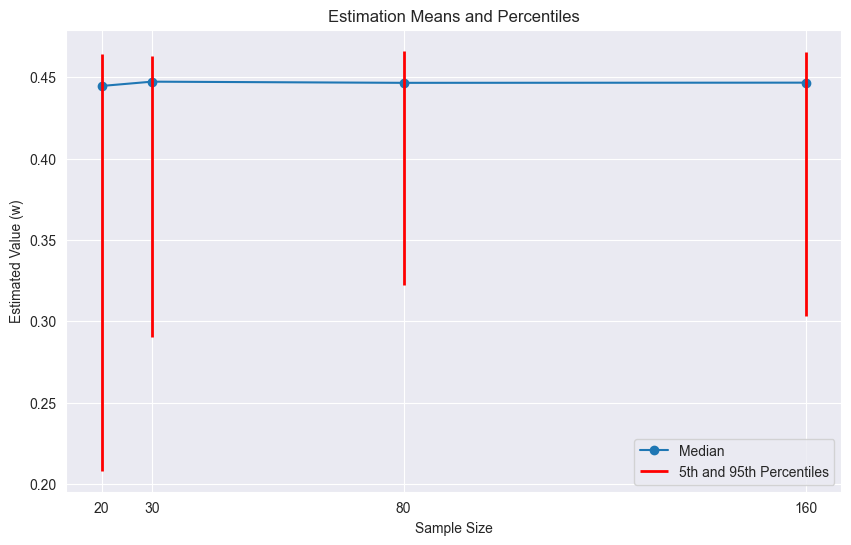

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Calculating averages
x = list(results.keys())
y_mean = [np.median(results[key]) for key in x]

# Calculating percentiles
y_5th = [np.percentile(results[key], 5) for key in x]
y_95th = [np.percentile(results[key], 95) for key in x]

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting means
plt.plot(x, y_mean, marker='o', linestyle='-')

# Plotting 5th and 95th percentiles
for i in range(len(x)):
    plt.vlines(x[i], y_5th[i], y_95th[i], colors='r', linestyles='solid', linewidth=2)

# Formatting the plot
plt.title('Estimation Means and Percentiles')
plt.xlabel('Sample Size')
plt.ylabel('Estimated Value (w)')
plt.grid(True)
plt.xticks(x)
plt.legend(['Median', '5th and 95th Percentiles'], loc='lower right')

# Displaying the plot
plt.show()